In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import glob
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Grad-CAM 및 시각화를 위한 추가 라이브러리 import
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
import cv2 # Grad-CAM에서 이미지 리사이징에 사용 (설치 필요: pip install opencv-python)

print(tf.__version__)
print(np.__version__)
print("PIL 라이브러리 import 완료!")

2.6.0
1.22.2
PIL 라이브러리 import 완료!


In [3]:
def set_deterministic_mode(seed_value):
    # 1. 파이썬, NumPy, TensorFlow의 난수 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    
    # 2. GPU 결정성 모드 강제 설정 (학습 속도 저하 가능성 있음)
    os.environ['TF_DETERMINISTIC_OPS'] = '1' 
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# 시드 값 설정 및 함수 호출
SEED = 42
set_deterministic_mode(SEED)

In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	print(len(images), " images to be resized.")

	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size, Image.LANCZOS)
		new_img.save(img, "JPEG")

	print(len(images), " images resized.")

# 모든 이미지 리사이즈 (가정: 훈련 데이터 경로)
image_dir_path_train_base = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
resize_images(image_dir_path_train_base + "/scissor")
resize_images(image_dir_path_train_base + "/rock")
resize_images(image_dir_path_train_base + "/paper")
print("훈련 이미지 resize 완료!")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
훈련 이미지 resize 완료!


In [5]:
# ⭐️ 4차 시도 변경점 1: 그레이 스케일 전환 ⭐️
def load_data(img_path, number_of_data):  # number_of_data를 명시적으로 받도록 수정
	# 가위 : 0, 바위 : 1, 보 : 2
	img_size=28
	color=1 # ⭐️ 컬러 채널 수 3 -> 1로 변경 (Gray Scale)
	
	# 배열 생성: (데이터 개수, 28, 28, 1)
	imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
	labels=np.zeros(number_of_data,dtype=np.int32)

	idx=0
	for file in glob.iglob(img_path+'/*/*.jpg'):
		if idx == number_of_data: break
		
		# ⭐️ Image.open().convert('L')을 사용하여 흑백으로 변환
		# 'L' 모드는 1채널 흑백 이미지 생성
		img = np.array(Image.open(file).convert('L'),dtype=np.int32)
		
		# 흑백 이미지는 (28, 28) 형태이므로 (28, 28, 1)로 reshape 필요
		imgs[idx,:,:,:]=img.reshape(img_size, img_size, color)
		
		# 파일 경로에서 라벨 추출
		if 'scissor' in file:
			labels[idx]=0
		elif 'rock' in file:
			labels[idx]=1
		elif 'paper' in file:
			labels[idx]=2
			
		idx=idx+1

	print("로드된 이미지 개수는", idx,"입니다.")
	return imgs[:idx], labels[:idx]

In [6]:
TRAIN_DATA_COUNT = 300
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train_raw, y_train)=load_data(image_dir_path, number_of_data=TRAIN_DATA_COUNT)
x_train = x_train_raw/255.0

print("\n--- 훈련 데이터 정보 (4차 시도: Gray Scale) ---")
print("x_train shape: {}".format(x_train.shape)) # (300, 28, 28, 1)이 나와야 함
print("y_train shape: {}".format(y_train.shape))

로드된 이미지 개수는 300 입니다.

--- 훈련 데이터 정보 (4차 시도: Gray Scale) ---
x_train shape: (300, 28, 28, 1)
y_train shape: (300,)


라벨:  0


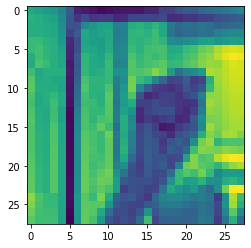

In [7]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [8]:
n_channel_1=32
n_channel_2=64
n_dense=128
n_train_epoch=20

model=keras.models.Sequential()
# ⭐️ 3차 시도 변경점 2: input_shape (28,28,3) -> (28,28,1)로 변경
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu', name='last_conv_layer')) 
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(3, activation='softmax'))

print("\n--- 모델 구조 (4차 시도: Gray Scale Input) ---")
model.summary()


--- 모델 구조 (4차 시도: Gray Scale Input) ---
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
last_conv_layer (Conv2D)     (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)  

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=15, zoom_range=0.1, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest'
)

BATCH_SIZE = 32
TRAIN_DATA_COUNT_ADJUSTED = x_train.shape[0] # 로드된 실제 데이터 개수 사용

print("\n--- 모델 훈련 (4차 시도: Gray Scale 적용) ---")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=False),
    epochs=n_train_epoch,
    steps_per_epoch=int(np.ceil(TRAIN_DATA_COUNT_ADJUSTED / BATCH_SIZE))
)


--- 모델 훈련 (4차 시도: Gray Scale 적용) ---
Epoch 1/20
10/10 [==============================] - 1s 42ms/step - loss: 0.1966 - accuracy: 0.9967
Epoch 2/20
10/10 [==============================] - 0s 46ms/step - loss: 3.0597e-08 - accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 0s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 0s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/20
10/10 [==============================] - 0s 49ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/20
10/10 [====================

In [10]:
image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
resize_images(image_dir_path_test + "/scissor")
resize_images(image_dir_path_test + "/rock")
resize_images(image_dir_path_test + "/paper")

TEST_DATA_COUNT = 313

(x_test_raw, y_test)=load_data(image_dir_path_test, number_of_data=TEST_DATA_COUNT)
x_test = x_test_raw/255.0

print("\n--- 테스트 데이터 정보 ---")
print("x_test shape: {}".format(x_test.shape)) # (313, 28, 28, 1)이 나와야 함
print("y_test shape: {}".format(y_test.shape))

print("\n--- 모델 성능 평가 ---")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {} ".format(test_accuracy))

107  images to be resized.
107  images resized.
102  images to be resized.
102  images resized.
104  images to be resized.
104  images resized.
로드된 이미지 개수는 313 입니다.

--- 테스트 데이터 정보 ---
x_test shape: (313, 28, 28, 1)
y_test shape: (313,)

--- 모델 성능 평가 ---
10/10 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
test_loss: 0.0 
test_accuracy: 1.0 


In [11]:
## Grad-CAM 함수 구현 (유지)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM 히트맵을 생성합니다."""
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Grad-CAM 히트맵을 원본 이미지에 겹쳐서 시각화합니다."""
    img = cv2.imread(img_path)
    # NOTE: 흑백 이미지 시각화를 위해 IMREAD_COLOR를 사용했더라도 RGB로 변환
    img = cv2.resize(img, (28, 28)) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 원본 이미지 (28, 28, 3) 

    # 히트맵을 이미지 크기에 맞게 리사이즈
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # 컬러맵 적용
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # 히트맵을 255 스케일로 변환
    jet_heatmap = np.uint8(255 * jet_heatmap)
    
    # 원본 이미지 위에 히트맵 오버레이
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Analysis")
    plt.axis('off')
    plt.show()


--- Grad-CAM 분석 예시 (바위) ---


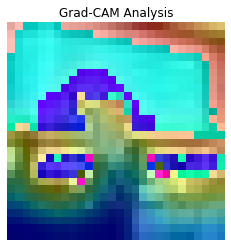


--- Grad-CAM 분석 예시 (보) ---


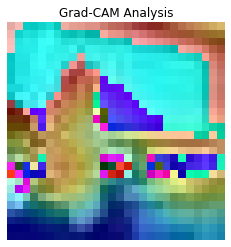


--- Grad-CAM 분석 예시 (가위) ---


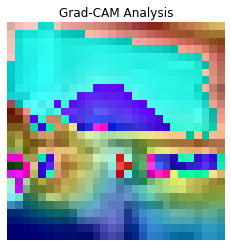

In [12]:
## Grad-CAM 실행 (클래스별 1장씩)
# NOTE: x_test의 형태가 (313, 28, 28, 1)로 바뀌었으므로, img_array는 흑백 데이터입니다.
# display_gradcam 함수는 내부에서 3채널로 시각화합니다.

# ... (기존 Grad-CAM 실행 코드 블록 3개 유지) ...
print("\n--- Grad-CAM 분석 예시 (바위) ---")
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock/0.jpg"
img_array = x_test[0:1] 
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

print("\n--- Grad-CAM 분석 예시 (보) ---")
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper/0.jpg"
img_array = x_test[1:2] # 다음 인덱스 사용
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

print("\n--- Grad-CAM 분석 예시 (가위) ---")
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor/0.jpg"
img_array = x_test[2:3] # 다음 인덱스 사용
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

In [13]:
## 가중치(Weights) 및 편향(Bias) 추출 (유지)
print("\n--- 가중치(Weights) 및 편향(Bias) 추출 ---")

conv1_layer = model.layers[0] 
weights_c1, biases_c1 = conv1_layer.get_weights() 
print("Conv1 레이어:")
# ⭐️ Gray Scale 적용으로 Weights shape이 (3, 3, 1, 32)로 바뀝니다.
print(f"  Weights shape (커널): {weights_c1.shape}") 
print(f"  Biases shape: {biases_c1.shape}") 

dense1_layer = model.layers[6] 
weights_d1, biases_d1 = dense1_layer.get_weights() 
print("Dense1 레이어:")
print(f"  Weights shape: {weights_d1.shape}") 
print(f"  Biases shape: {biases_d1.shape}")


--- 가중치(Weights) 및 편향(Bias) 추출 ---
Conv1 레이어:
  Weights shape (커널): (3, 3, 1, 32)
  Biases shape: (32,)
Dense1 레이어:
  Weights shape: (1600, 128)
  Biases shape: (128,)


In [14]:
# Conv1 가중치 통계량 출력
print("\n--- Conv1 Weights (커널 값) 통계 ---")
print(f"  Min: {np.min(weights_c1):.6f}")
print(f"  Max: {np.max(weights_c1):.6f}")
print(f"  Mean: {np.mean(weights_c1):.6f}")
print(f"  Std Dev: {np.std(weights_c1):.6f}") # ⭐️ 이 값의 증가 여부 확인

print("\n--- Dense1 Weights 통계 ---")
print(f"  Min: {np.min(weights_d1):.6f}")
print(f"  Max: {np.max(weights_d1):.6f}")
print(f"  Mean: {np.mean(weights_d1):.6f}")
print(f"  Std Dev: {np.std(weights_d1):.6f}")


--- Conv1 Weights (커널 값) 통계 ---
  Min: -0.153062
  Max: 0.147552
  Mean: 0.006361
  Std Dev: 0.080738

--- Dense1 Weights 통계 ---
  Min: -0.068836
  Max: 0.071292
  Mean: 0.001941
  Std Dev: 0.034754



--- Conv1 가중치 시각화 (학습된 필터 확인) ---


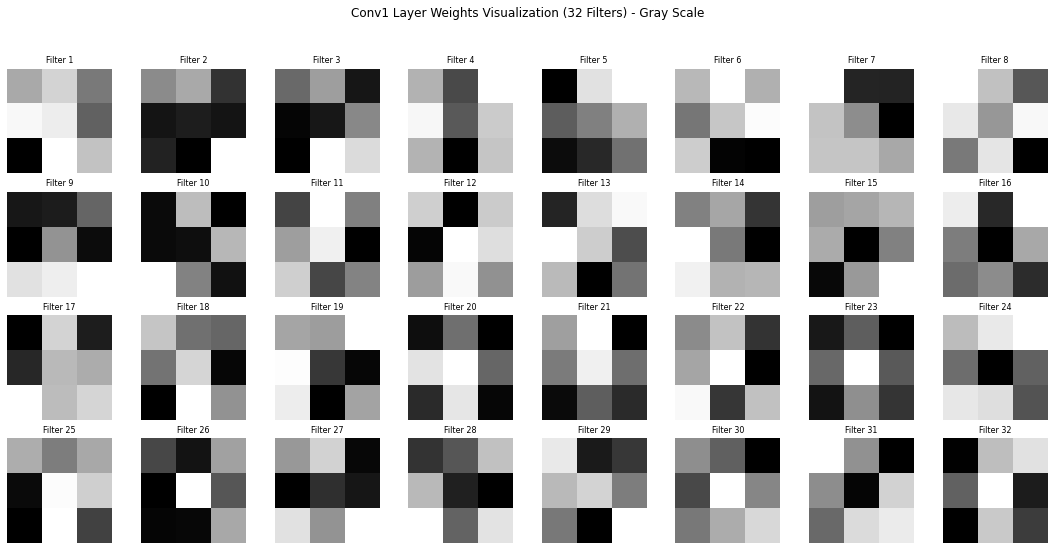

In [15]:
# Conv1 가중치 시각화 함수 (흑백 이미지에 맞춰 1채널 시각화로 변경)
def visualize_conv_weights(weights):
    # weights shape: (커널 높이, 커널 너비, 입력 채널, 출력 채널) = (3, 3, 1, 32)
    
    num_filters = weights.shape[3] # 32개 필터
    
    # 시각화를 위해 4x8 격자로 설정
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # i번째 필터의 가중치를 가져옴 (3, 3, 1) -> (3, 3)
            filter_weights = weights[:, :, 0, i] # 1채널만 사용
            
            # 필터 내의 최솟값/최댓값을 찾아서 0~1로 스케일링
            min_val = np.min(filter_weights)
            max_val = np.max(filter_weights)
            normalized_filter = (filter_weights - min_val) / (max_val - min_val)
            
            # 흑백(Gray scale)로 시각화: cmap='gray'
            ax.imshow(normalized_filter, cmap='gray') 
            ax.set_title(f'Filter {i+1}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')
            
    plt.suptitle("Conv1 Layer Weights Visualization (32 Filters) - Gray Scale")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\n--- Conv1 가중치 시각화 (학습된 필터 확인) ---")
visualize_conv_weights(weights_c1)


--- Conv1 편향 분포 분석 ---


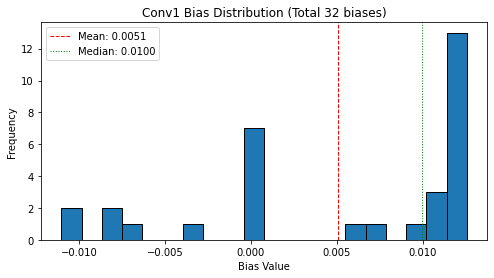


--- Dense1 편향 분포 분석 ---


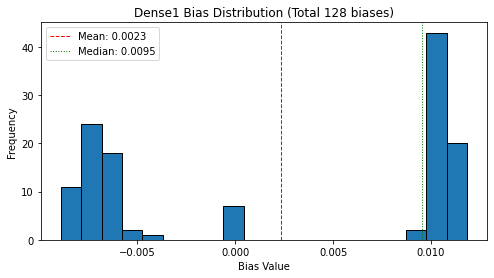

In [16]:
# 편향 값의 분포 분석 (히스토그램) (유지)
def visualize_bias_distribution(biases, layer_name):
    plt.figure(figsize=(8, 4))
    plt.hist(biases, bins=20, edgecolor='black')
    
    mean_bias = np.mean(biases)
    median_bias = np.median(biases)
    plt.axvline(mean_bias, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bias:.4f}')
    plt.axvline(median_bias, color='g', linestyle='dotted', linewidth=1, label=f'Median: {median_bias:.4f}')
    
    plt.title(f'{layer_name} Bias Distribution (Total {len(biases)} biases)')
    plt.xlabel("Bias Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

print("\n--- Conv1 편향 분포 분석 ---")
visualize_bias_distribution(biases_c1, "Conv1")

print("\n--- Dense1 편향 분포 분석 ---")
visualize_bias_distribution(biases_d1, "Dense1")